# Day 08. Exercise 03
# Overfitting

## 0. Imports

In [127]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
import joblib

## 1. Preprocessing

1. Read the file `dayofweek.csv` to a dataframe.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test`.
3. Using, for example, `value_counts()` to check if the distribution of classes is similar in train and test.
4. Use the additional parameter `stratify=` and check the distribution again, now it should be more or less similar in both datasets.

In [128]:
df = pd.read_csv('../data/dayofweek.csv')
print(df)

      numTrials      hour  dayofweek  uid_user_0  uid_user_1  uid_user_10  \
0     -0.788667 -2.562352          4         0.0         0.0          0.0   
1     -0.756764 -2.562352          4         0.0         0.0          0.0   
2     -0.724861 -2.562352          4         0.0         0.0          0.0   
3     -0.692958 -2.562352          4         0.0         0.0          0.0   
4     -0.661055 -2.562352          4         0.0         0.0          0.0   
...         ...       ...        ...         ...         ...          ...   
1681  -0.533442  0.945382          3         0.0         0.0          0.0   
1682  -0.629151  0.945382          3         0.0         1.0          0.0   
1683  -0.597248  0.945382          3         0.0         1.0          0.0   
1684  -0.565345  0.945382          3         0.0         1.0          0.0   
1685  -0.533442  0.945382          3         0.0         1.0          0.0   

      uid_user_11  uid_user_12  uid_user_13  uid_user_14  ...  labname_lab0

In [129]:
X = df.drop(['dayofweek'], axis=1)
y = df['dayofweek']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [131]:
y_train.value_counts(normalize=True)

dayofweek
3    0.232196
6    0.212908
1    0.164688
5    0.160237
2    0.092730
0    0.077893
4    0.059347
Name: proportion, dtype: float64

In [132]:
y_test.value_counts(normalize=True)

dayofweek
3    0.245562
6    0.204142
5    0.162722
1    0.153846
0    0.091716
4    0.071006
2    0.071006
Name: proportion, dtype: float64

In [133]:
X_strain, X_stest, y_strain, y_stest = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [134]:
y_strain.value_counts(normalize=True)

dayofweek
3    0.234421
6    0.211424
1    0.162463
5    0.160979
2    0.088279
0    0.080861
4    0.061573
Name: proportion, dtype: float64

In [135]:
y_stest.value_counts(normalize=True)

dayofweek
3    0.236686
6    0.210059
1    0.162722
5    0.159763
2    0.088757
0    0.079882
4    0.062130
Name: proportion, dtype: float64

## 2. Baseline models

1. Train exactly the same baseline models from the previous exercise and calculate the accuracies using the test dataset with stratification.
2. Did all the models show the similar values of the metric? Which one has the largest difference comparing the current exercise and the previous? Put the answer to the markdown cell in the end of the section.

### a. Logreg

In [136]:
base_logreg = LogisticRegression(solver='liblinear', random_state=21, fit_intercept=False, max_iter=100)
logreg = OneVsRestClassifier(base_logreg)
logreg.fit(X_train,y_train)

,estimator,LogisticRegre...r='liblinear')
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,21


In [137]:
y_pred_logreg = logreg.predict(X_stest)
logreg_accuracy = metrics.accuracy_score(y_stest, y_pred_logreg)
logreg_accuracy

0.6272189349112426

In [138]:
logreg_accuracy-0.6209964412811388

0.006222493630103743

### b. SVM

In [139]:
svc_linear = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21))
svc_linear.fit(X_strain,y_strain)
y_pred_svc = svc_linear.predict(X_stest)
svm_accuracy = metrics.accuracy_score(y_stest, y_pred_svc)
svm_accuracy

0.6183431952662722

In [140]:
svm_accuracy-0.6126927639383155

0.005650431327956729

### c. Decision tree

In [141]:
tree = DecisionTreeClassifier(max_depth = 4, random_state = 21)
tree.fit(X_strain,y_strain)
tree_pred = tree.predict(X_stest)
dt_accuracy = metrics.accuracy_score(y_stest, tree_pred)
dt_accuracy

0.5295857988165681

In [142]:
dt_accuracy-0.5516014234875445

-0.022015624670976397

### d. Random forest

In [143]:
forest = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
forest.fit(X_strain,y_strain)
forest_pred = forest.predict(X_stest)
rf_accuracy = metrics.accuracy_score(y_stest, forest_pred)
rf_accuracy

0.9289940828402367

In [144]:
rf_accuracy-1.0

-0.07100591715976334

## Answer: random_forest

## 3. Crossvalidation

We could play with parameters of the model trying to achive a better accuracy on the test dataset, but it is a bad practice. It leads us again to overfitting. Test dataset is only for checking quality of a final model.

But there is another way of solving the problem – crossvalidation. It does not use test dataset, but creates one more split of train dataset. Again, there are different ways of doing it, but the common thing is that there is a validation dataset that is used for hyperparameters optimization.

1. Using `cross_val_score` with `cv=10` calculate the mean accuracy and standard deviation for every model that you used before (logreg with `solver='liblinear'`, SVC, decision tree, random forest).

### a. Logreg

In [145]:
score = cross_val_score(logreg, X_strain, y_strain, cv=10, scoring='accuracy')

In [146]:
np.mean(score)

np.float64(0.5815975677169707)

In [147]:
np.std(score)

np.float64(0.025322132907253592)

### b. SVM

In [148]:
score = cross_val_score(svc_linear, X_strain, y_strain, cv=10, scoring='accuracy')

In [149]:
np.mean(score)

np.float64(0.5705085682697624)

In [150]:
np.std(score)

np.float64(0.037010421284044116)

### c. Decision tree

In [151]:
score = cross_val_score(tree, X_strain, y_strain, cv=10, scoring='accuracy')

In [152]:
np.mean(score)

np.float64(0.5088944168048645)

In [153]:
np.std(score)

np.float64(0.031903139495514356)

### d. Random forest

In [154]:
score = cross_val_score(forest, X_strain, y_strain, cv=10, scoring='accuracy')

In [155]:
np.mean(score)

np.float64(0.9176561636263129)

In [156]:
np.std(score)

np.float64(0.02159583796321821)

## Best model: random forest

## The worst model: decision tree

## 4. Optimization

1. Choose the best model and play a little bit with the parameters on cross-validation, find a good enough parameter or a combination of the parameters.
2. Calculate the accuracy for the final model on the test dataset.
3. Draw a plot that displays the top-10 most  important features for that model.
4. Save the model using `joblib`.
5. Load the model, make predictions for the test dataset and calculate the accuracy.

In [157]:
depths = [10, 25, 50]
estimators = [50, 100, 200]
best_accuracy = 0
best_params = None
best_rf = None

In [158]:
for depth in depths:
    for n_est in estimators:
        rf = RandomForestClassifier(max_depth=depth, n_estimators=n_est, random_state=21)
        scores = cross_val_score(rf, X_strain, y_strain, cv=10)
        mean_accuracy = scores.mean()
        print(f'Random Forest CV (max_depth={depth}, n_estimators={n_est}): {mean_accuracy:.4f}')
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_params = (depth, n_est)
            best_rf = rf

Random Forest CV (max_depth=10, n_estimators=50): 0.7952
Random Forest CV (max_depth=10, n_estimators=100): 0.8019
Random Forest CV (max_depth=10, n_estimators=200): 0.8108
Random Forest CV (max_depth=25, n_estimators=50): 0.9147
Random Forest CV (max_depth=25, n_estimators=100): 0.9177
Random Forest CV (max_depth=25, n_estimators=200): 0.9169
Random Forest CV (max_depth=50, n_estimators=50): 0.9139
Random Forest CV (max_depth=50, n_estimators=100): 0.9147
Random Forest CV (max_depth=50, n_estimators=200): 0.9147


In [159]:
best_rf.fit(X_strain, y_strain)
y_pred_best = best_rf.predict(X_stest)
best_accuracy_test = metrics.accuracy_score(y_stest, y_pred_best)
print(f'Best Random Forest (max_depth={best_params[0]}, n_estimators={best_params[1]}) test accuracy: {best_accuracy_test:.4f}')

Best Random Forest (max_depth=25, n_estimators=100) test accuracy: 0.9290


In [160]:
def plot_feature_importance(coefficients, feature_names, top_n=10):
    importance = np.abs(coefficients)
    feature_importance = pd.Series(importance, index=feature_names)
    top_features = feature_importance.nlargest(top_n)
    plt.figure(figsize=(10, 6))
    top_features.plot(kind='barh')
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

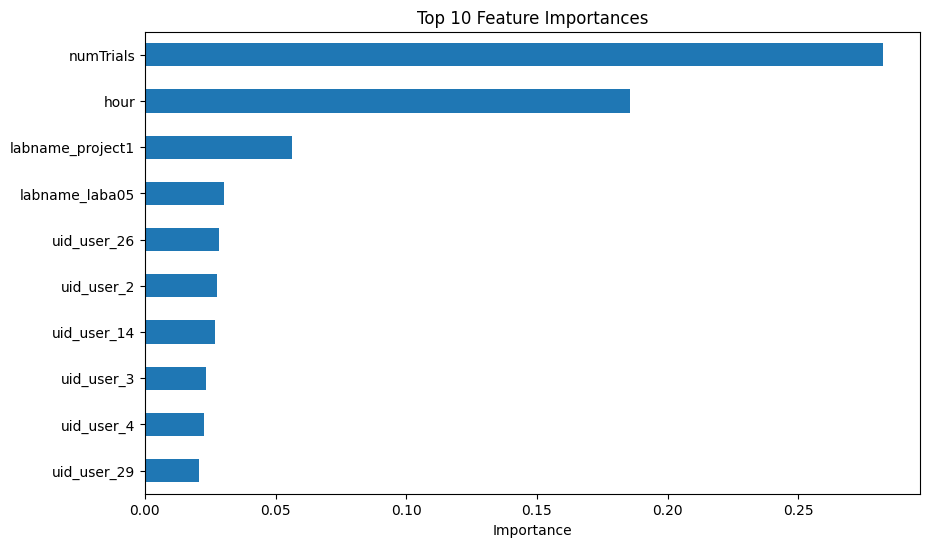

In [161]:
plot_feature_importance(best_rf.feature_importances_, X.columns, top_n=10)

In [162]:
os.makedirs('../data/models', exist_ok=True)

In [163]:
joblib.dump(best_rf, '../data/models/best_rf_model.joblib')

['../data/models/best_rf_model.joblib']

In [164]:
loaded_rf = joblib.load('../data/models/best_rf_model.joblib')
y_pred_loaded = loaded_rf.predict(X_stest)
loaded_accuracy = metrics.accuracy_score(y_stest, y_pred_loaded)
print(f'Loaded Random Forest test accuracy: {loaded_accuracy}')

Loaded Random Forest test accuracy: 0.9289940828402367
